In [804]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In [805]:
# la bound
# lb bound
# ht bound


In [806]:
def gen_deadline(exec_time, period):
    # [a,b]
    b = 1.2 * period
    if(exec_time < 10):
        a = exec_time
    elif(exec_time < 100 and exec_time >= 10):
        a = 2*exec_time
    elif(exec_time < 1000 and exec_time >= 100):
        a = 3*exec_time
    else:
        a = 4*exec_time

    return a+random.random()*(b-a)


def gen_tasksets(utilizations, periods):
    """
    Take a list of task utilization sets and a list of task period sets and
    return a list of couples (c, p) sets. The computation times are truncated
    at a precision of 10^-10 to avoid floating point precision errors.
    Args:
        - `utilization`: The list of task utilization sets. For example::
            [[0.3, 0.4, 0.8], [0.1, 0.9, 0.5]]
        - `periods`: The list of task period sets. For examples::
            [[100, 50, 1000], [200, 500, 10]]
    Returns:
        For the above example, it returns::
            [[(30.0, 100), (20.0, 50), (800.0, 1000)],
             [(20.0, 200), (450.0, 500), (5.0, 10)]]
    """
    def trunc(x, p):
        return int(x * 10 ** p) / float(10 ** p)
    # [[print(ui) for ui, pi in zip(us, ps)]
    #         for us, ps in zip(utilizations, periods)]
    return np.array([[[trunc(ui * pi, 6), trunc(pi, 6), trunc(gen_deadline(trunc(ui * pi, 6), trunc(pi, 6)), 6)] for ui, pi in zip(us, ps)]
            for us, ps in zip(utilizations, periods)])


In [807]:
def custom_period(n, nsets,max_,min_=0):
	max_power = np.log(max_)


	intervals = np.arange(0,np.floor(max_power)+1)
	intervals = np.append(intervals, max_power)
	#print(intervals)
	task_pp = ((n-1)//(len(intervals)-1))
	
	task_lf = np.mod(n-1, len(intervals)-1).astype(int)
	#print(task_lf,task_pp)
	periods = np.zeros((nsets, n))
	for i in range(nsets):
		for j in range(len(intervals)-1):
			if(j<task_lf):
				periods[i][j*task_pp+j:(j+1)*task_pp+j+1] = np.random.uniform(low=np.exp(intervals[j]), high=np.exp(intervals[j+1]), size=task_pp+1)
			else:
				periods[i][j*task_pp+task_lf:(j+1)*task_pp+task_lf] = np.random.uniform(low=np.exp(intervals[j]), high=np.exp(intervals[j+1]), size=task_pp)
	periods[0:nsets,-1] =max_ 
	return periods


In [808]:
custom_period(14,2,100)

array([[  1.69118469,   2.50405235,   2.14329864,   6.01999225,
          3.8469321 ,   5.04954801,  18.44079229,  11.62036636,
         18.57310838,  48.30773295,  44.54173887,  97.91894767,
         82.22153597, 100.        ],
       [  2.40718125,   1.2348009 ,   1.23409784,   5.279604  ,
          3.25112872,   4.42378388,  11.14065946,  11.41513561,
         19.40173756,  24.63179974,  28.982189  ,  58.615245  ,
         72.72111359, 100.        ]])

In [809]:
def UUniFastDiscard(n, u, nsets):
    sets = []
    while len(sets) < nsets:
        # Classic UUniFast algorithm:
        utilizations = []
        sumU = u
        for i in range(1, n):
            nextSumU = sumU * random.random() ** (1.0 / (n - i))
            utilizations.append(sumU - nextSumU)
            sumU = nextSumU
        utilizations.append(sumU)

        # If no task utilization exceeds 1:
        if all(ut <= 1 for ut in utilizations):
            sets.append(utilizations)

    return sets

    
def gen_uunifastdiscard(nsets, u, n):
    """
    The UUniFast algorithm was proposed by Bini for generating task
    utilizations on uniprocessor architectures.
    The UUniFast-Discard algorithm extends it to multiprocessor by
    discarding task sets containing any utilization that exceeds 1.
    This algorithm is easy and widely used. However, it suffers from very
    long computation times when n is close to u. Stafford's algorithm is
    faster.
    Args:
        - `n`: The number of tasks in a task set.
        - `u`: Total utilization of the task set.
        - `nsets`: Number of sets to generate.
    Returns `nsets` of `n` task utilizations.
    """
    return UUniFastDiscard(n, u, nsets)

In [810]:
def get_taskset(nsets, n):
	u = 0.9
	#n = 1000
	utilizations = gen_uunifastdiscard(nsets, u, n)
	periods = custom_period(n, nsets, 1000, 10)
	return gen_tasksets(utilizations, periods)

	

In [811]:
taskset_paper = np.array([[6000, 18000, 31000], [2000, 9000, 9800], [1000, 12000, 17000], [
                         90, 3000, 4200], [8, 78, 96], [2, 16, 12], [10, 120, 280], [26, 160, 660]])


In [812]:
def procDemand_func(taskset,t):
    deadlines = taskset[:,1]
    periods = taskset[:,2]
    wcet = taskset[:,0]
    
    #utilizations = wcet/periods #wcet/periods
	#print(deadlines, periods, utilizations)
    #total_utilization = np.sum(utilizations)

    #task_done = (1 + np.floor((t-deadlines)/(periods)))*taskset[:,0]#wcet
    h_t = np.sum(np.maximum(0, 1 + np.floor((t-deadlines)/(periods)))*wcet)

    # task_done[task_done<0] = 0
    # print(task_done)

    # h_t = np.sum(task_done)

    return h_t

In [813]:
t = 16974
ht = procDemand_func(taskset_paper, t)
#print(ht)

In [814]:
# def get_La(taskset):
#     deadlines = taskset[:,2]
#     periods = taskset[:,1]
#     utilizations = taskset[:,0]/taskset[:,1]
# 	#print(deadlines, periods, utilizations)
#     total_utilization = np.sum(utilizations)
# 	#print(np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
#     La = np.max(np.max(deadlines),np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
#     return La

In [815]:
taskset_paper = np.array([[6000, 18000, 31000], [2000, 9000, 9800], [1000, 12000, 17000], [90, 3000, 4200], [8, 78, 96], [2, 16, 12], [10, 120, 280], [26, 160, 660]])

In [816]:
def La_bound(taskset):
	"""
	Compute La calculations for the La bound
	
	"""
	wcet = taskset[:,0]
	deadlines = taskset[:,1]
	periods = taskset[:,2]
	utilizations = wcet/periods
	#print("deadlines", deadlines, "periods", periods, "utilizations", utilizations)
	#print(deadlines, periods, utilizations)
	total_utilization = np.sum(utilizations)
	#print("total utilization : " + str(total_utilization))
	#print(np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
	#La = np.maximum(np.max(deadlines),np.max((periods-deadlines))*(total_utilization/(1-total_utilization)))
	print(np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
	La = np.maximum(np.max(deadlines),np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
	return La


In [817]:
taskset = get_taskset(1, 18)
print(taskset)
La = La_bound(taskset[0])
taskset[:,0]/taskset[:,1]
print(La)

[[[2.81090000e-02 2.07914800e+00 1.25130800e+00]
  [1.22832000e-01 2.45404100e+00 2.53828000e-01]
  [9.51730000e-02 1.87139700e+00 2.24074700e+00]
  [4.47089000e-01 6.46324900e+00 5.95776900e+00]
  [1.45020000e-02 3.77241700e+00 6.02330000e-01]
  [6.67310000e-02 6.80206800e+00 7.27825500e+00]
  [3.21670000e-02 1.10356510e+01 8.32180500e+00]
  [1.08439100e+00 1.14783450e+01 6.47223600e+00]
  [4.40347000e-01 1.09120170e+01 1.52352600e+00]
  [8.65953000e-01 2.98206030e+01 5.82018300e+00]
  [1.05700810e+01 5.02976690e+01 5.87900200e+01]
  [1.92923000e-01 7.30076940e+01 2.34416050e+01]
  [3.50228000e+00 1.02764628e+02 8.01786190e+01]
  [3.75693600e+00 2.20221866e+02 1.96827236e+02]
  [1.20115720e+01 1.52538379e+02 3.65654580e+01]
  [1.46463690e+01 9.90135572e+02 1.03249906e+03]
  [7.69443440e+01 4.71983490e+02 3.55272817e+02]
  [1.54670010e+01 1.00000000e+03 9.23383306e+02]]]
66.48667833419866
1000.0


In [818]:
def Lb_bound(taskset):
    "A synchronous busy period is a processor busy period in which all tasks are release simultaneously at the beginning of the processor busy period, and then, at their maximum rate, and ended by the first processor idle period(the length of such a period can be zero). The length of the synchronous busy period Lb can be computed by the following process"
    wcet = taskset[:,0]
    deadlines = taskset[:,1]
    periods = taskset[:,2]
    w0 = np.sum(wcet)
    a = w0
    #b =0
    # for i in range(0,len(periods)):
    #     b += np.ceil(a/periods[i])*wcet[i]
    b = np.sum(np.ceil(a/periods)*wcet)
    while a != b:
        a = b
        b = np.sum(np.ceil(a/periods)*wcet)
        # for i in range(0,len(periods)):
        #     print(a, periods[i], wcet[i])
        #     b += np.ceil(a/periods[i])*wcet[i]
    Lb = b
    
    return Lb

In [819]:
Lb = Lb_bound(taskset_paper)
print(Lb)

16984.0


In [820]:
deadlines = taskset_paper[:, 1]
d_min = np.min(deadlines)
print(d_min)

16


In [821]:
def get_dmin(deadliness, L):
    return np.min(deadliness)
    
    

In [822]:
deadlines = taskset_paper[:, 1]
L = np.minimum(La, Lb)
d_min = get_dmin(deadlines, L)
print(d_min)

# t = np.min(deadlines < L)
# print(t)


16


In [823]:
taskset_paper.shape

(8, 3)

In [824]:
def get_max_abs_deadline(taskset, L):
    n = taskset.shape[0]
    abs_deadlines = []
    
    for i in range(n):
        p = 0
        j = 0
        Ti = taskset[i][2]
        Di = taskset[i][1]
        while p < L:
            j += 1
            q = p
            p = j*Ti + Di
            
        abs_deadlines.append(q)
    return np.max(abs_deadlines)
    

In [825]:
L = 16984
t = get_max_abs_deadline(taskset_paper, L)

print(t)

16974


In [826]:
def get_max_di(taskset, t):
    n = taskset.shape[0]
    d_max = 0
    
    for j in range(n):
        if taskset[j][1] < t:
            d = np.floor((t - taskset[j][1])/taskset[j][2])*taskset[j][2] + taskset[j][1]
            if d == t:
                d = d - taskset[j][2]
            if d > d_max:
                d_max = d
                
    return d_max
    
    

In [827]:
def qpa(taskset):
    
    La = La_bound(taskset)
    #print("La : " + str(La))
    #Lb = Lb_bound(taskset)
    #print("Lb : " + str(Lb))
    L =La

    print("L : " + str(L))
    
    t = get_max_abs_deadline(taskset, L)
    print("t : " + str(t))
    h_t = procDemand_func(taskset, t)
    print("h(t) : " + str(h_t))
    d_min = get_dmin(taskset[:,1], L)
    #print("d_min : " + str(d_min))
    #print("did not enter yet")
    total_calc = 1
    while h_t <= t and h_t > d_min:
        h_t = procDemand_func(taskset, t)
        #print("came")
        #print("t:" + str(t) + "ht" + str(h_t))
        if h_t < t:
            t = h_t
        else:
            d_max = get_max_di(taskset, t)
            t = d_max
        total_calc+=1
    
   #print("don't know if it went")
    
    # if h_t <= d_min:
    #     print("Task set is schedulable")
    # else:
    #     print("Task set is not schedulable")
    print("total calculations : " + str(total_calc))
    return total_calc
        

    

In [828]:
taskset = get_taskset(1,10)
print(taskset[0])
qpa(taskset[0])

[[3.21701000e-01 2.65925000e+00 1.63881200e+00]
 [8.62600000e-03 2.20223500e+00 5.15835000e-01]
 [2.05055000e-01 6.07453900e+00 3.44262000e-01]
 [6.06666000e-01 6.72150500e+00 6.49602200e+00]
 [2.03217000e-01 1.40782890e+01 5.71676300e+00]
 [1.32009550e+01 4.21631660e+01 3.37675580e+01]
 [2.66511700e+01 1.31598529e+02 9.57334200e+01]
 [3.02311200e+00 1.66301992e+02 1.80633577e+02]
 [3.44502350e+01 5.94593756e+02 4.17154937e+02]
 [4.49310730e+01 1.00000000e+03 2.17341696e+02]]
211.87832749636357
L : 1000.0
t : 999.958933
h(t) : 1631.687688
total calculations : 1


1

In [829]:
def La_boudcalculations(taskset):
	La = La_bound(taskset)
	print("La : " + str(La))
	wcet = taskset[:,0]
	deadlines = taskset[:,1]
	periods = taskset[:,2]
	tot_abs_deadlines = 0
	for job in taskset:
		job_abs_deadline=0
		if(job[1] <= job[2]):
			job_abs_deadline = np.floor((La)/job[2])
			if(job_abs_deadline*job[2]+job[1]<=La):
				job_abs_deadline = job_abs_deadline+1
		else:
			job_abs_deadline = np.floor((La)/job[1])
		tot_abs_deadlines +=job_abs_deadline
		print(job_abs_deadline, job[1], job[2])
	return tot_abs_deadlines

In [830]:
print(La_boudcalculations(get_taskset(1,18)))

3.236290723035259
La : 3.236290723035259


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
def Lb_boudcalculations(taskset):
	Lb = Lb_bound(taskset)
	wcet = taskset[:,0]
	deadlines = taskset[:,1]
	periods = taskset[:,2]
	tot_abs_deadlines = 0
	print(Lb)
	for job in taskset:
		job_abs_deadline=0
		if(job[1] <= job[2]):
			job_abs_deadline = np.floor((Lb)/job[2])
			if(job_abs_deadline*job[2]+job[1]<=La):
				job_abs_deadline = job_abs_deadline+1
		else:
			job_abs_deadline = np.floor((Lb)/job[2])
		tot_abs_deadlines +=job_abs_deadline
		print(job_abs_deadline, job[1], job[2])
	return tot_abs_deadlines

In [ ]:
print(Lb_boudcalculations(taskset_paper))

'''Using the minimum value mean, there are 1,638
absolute deadlines that must be checked by the old
approach.'''

16984.0
1.0 18000 31000
1.0 9000 9800
1.0 12000 17000
4.0 3000 4200
177.0 78 96
1415.0 16 12
61.0 120 280
26.0 160 660
1686.0


'Using the minimum value mean, there are 1,638\nabsolute deadlines that must be checked by the old\napproach.'

In [ ]:
def La_starbound(taskset):
	"""
	Compute La calculations for the La bound
	
	"""
	wcet = taskset[:,0]
	deadlines = taskset[:,1]
	periods = taskset[:,2]
	utilizations = wcet/periods
	#print("deadlines", deadlines, "periods", periods, "utilizations", utilizations)
	#print(deadlines, periods, utilizations)
	total_utilization = np.sum(utilizations)
	#print("total utilization : " + str(total_utilization))
	#print(np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
	#La = np.maximum(np.max(deadlines),np.max((periods-deadlines))*(total_utilization/(1-total_utilization)))
	print(np.max(deadlines))
	La = np.maximum(np.max(deadlines-periods),np.sum((periods-deadlines)*utilizations)/(1-total_utilization))
	return La

In [ ]:
def La_starcalculations(taskset):
	La_star = La_starbound(taskset)
	wcet = taskset[:,0]
	deadlines = taskset[:,1]
	periods = taskset[:,2]
	tot_abs_deadlines = 0
	for job in taskset:
		job_abs_deadline=0
		if(job[1] <= job[2]):
			job_abs_deadline = np.floor((La_star)/job[2])
			if(job_abs_deadline*job[2]+job[1]<=La):
				job_abs_deadline = job_abs_deadline+1
		else:
			job_abs_deadline = np.floor((La_star)/job[2])
		tot_abs_deadlines +=job_abs_deadline
		print(job_abs_deadline, job[1], job[2])
	return tot_abs_deadlines

In [ ]:
print(La_starcalculations(taskset_paper))


18000
1.0 18000 31000
1.0 9000 9800
1.0 12000 17000
4.0 3000 4200
160.0 78 96
1279.0 16 12
55.0 120 280
24.0 160 660
1525.0


# Plotting

### 1. h(t) calculations vs number of tasks.

In [ ]:
x =[]
for i in range(1,5):
	x.append(int(((2**i)-(2**(i-1)))*np.random.uniform(0, 1)+2**(i-1)))
	
qpa_y =[]
for i in x:
	print(i)
	taskset = get_taskset(1,int(i))
	qpa_y.append(qpa(taskset[0]))




1
L : 1000.0
t : 999.790095
h(t) : 2811.122314
total calculations : 1
3
L : 1000.0
t : 999.9735379999998
h(t) : 2615.811855
total calculations : 1
5
L : 1000.0
t : 999.8067599999999
h(t) : 1616.6109090000002
total calculations : 1
9
L : 1000.0
t : 999.992372
h(t) : 1595.195809
total calculations : 1


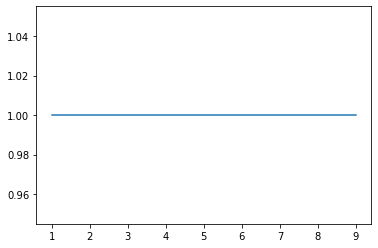

In [ ]:

plt.plot(x, qpa_y)